In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from datasets import load_dataset

In [2]:
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skills: ast.literal_eval(skills) if pd.notna(skills) else skills)

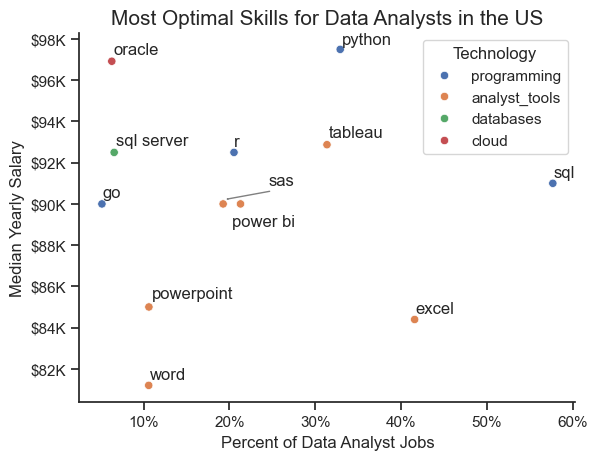

In [86]:

df_DA_US = df[(df['job_country'] == 'United States') & (df['job_title_short'] == 'Data Analyst')].copy()
df_DA_US.dropna(subset='salary_year_avg', inplace=True)

df_DA_US_explode = df_DA_US.explode('job_skills')

df_skill_salary_group = df_DA_US_explode.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

# Rename each columns
df_skill_salary_group = df_skill_salary_group.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

# -------------------- CALCULATE PERCENTAGE --------------------

total_jobs = len(df_DA_US)
df_skill_salary_group['skill_percent'] = (df_skill_salary_group['skill_count'] / total_jobs) * 100
skill_percent = 5 # Specify the minimum percentage to filter the dataset
df_DA_skill_high_demand = df_skill_salary_group[df_skill_salary_group['skill_percent'] > skill_percent]

# -------------------- CATEGORIZE BASED ON CORE TECHNOLOGIES --------------------

df_technology = df['job_type_skills'].copy()
df_technology = df_technology.drop_duplicates() # Remove duplicates
df_technology = df_technology.dropna() # Drop all NaN values across all columns

technology_dict = {}

for row in df_technology:
    row_dict = ast.literal_eval(row) # Use literal_eval to convert the string into a dictionary
    for key, value in row_dict.items():
        if key in technology_dict:
            technology_dict[key] += value
        else:
            technology_dict[key] = value

# Remove duplicate values in technology_dict
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_plot = df_DA_skill_high_demand.merge(df_technology, left_on='job_skills', right_on='skills').drop_duplicates(subset='skills').set_index('skills')

# -------------------- PLOTTING --------------------

from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

sns.set_theme(style='ticks')

sns.scatterplot(data=df_plot, x='skill_percent', y='median_salary', hue='technology')
sns.despine()

plt.title('Most Optimal Skills for Data Analysts in the US', fontsize=15)
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.legend(title='Technology')

ax=plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter())
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))

# Create a list variable for adjust_text()
texts = []

for i, txt in enumerate(df_plot.index):
    x = df_plot['skill_percent'].iloc[i]
    y = df_plot['median_salary'].iloc[i]
    texts.append(plt.text(x, y + 200, txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=1)) # lw= line width

# Adjust SAS and Power BI label positions to prevent overlap
for t in texts:
    if t.get_text() == "sas":
        t.set_position((t.get_position()[0]+1, t.get_position()[1]+500))
    if t.get_text() == "power bi":
        t.set_position((t.get_position()[0]-1, t.get_position()[1]-1500))

plt.show()